In [36]:
import torch
import itertools
import numpy as np
from scipy.linalg import det
import time

def get_I_a_list(N):
    n = N//2
    I_list = list(itertools.combinations(range(1, N+1), 2))
    a_list = list(itertools.combinations(range(1, N+1), n))
    num_I = len(I_list)
    num_a = len(a_list)
    return I_list, a_list, num_I, num_a

N = 12
I_list, a_list, num_I, num_a = get_I_a_list(N)

# define various psi states
def psi_product_state(num_a):
    psi = torch.zeros(num_a)
    psi[0] = 1.
    return psi

def psi_random(num_a):
    psi = 2 * torch.rand(num_a) - 1.
    psi /= psi.norm()
    return psi

def psi_equal_superposition(num_a):
    psi = torch.ones(num_a)
    psi /= psi.norm()
    return psi

psi = psi_random(num_a)

# Convert to tensors for vectorized processing
I_tensor = torch.tensor(I_list)  # (45, 2)
a_tensor = torch.tensor(a_list)  # (120, 3)

# Create empty tensor
J1 = torch.zeros((num_I, num_I, num_a))
J2 = torch.zeros((num_I, num_I, num_a))

# Levi-Civita sign function
def levi_civita_sign(big_set, sub_set):
    """
    Compute the sign of the permutation from sub_set + rest to big_set
    """
    perm = list(sub_set) + [x for x in big_set if x not in sub_set]
    idxs = [big_set.index(x) for x in perm]
    parity = np.array(idxs)
    sign = np.linalg.det(np.eye(len(parity))[parity])
    return int(round(sign))

def levi_civita_sign_optimized(big_set, sub_set):
    perm = list(sub_set) + [x for x in big_set if x not in sub_set]
    
    # Create a mapping from value to position
    value_to_pos = {val: pos for pos, val in enumerate(perm)}
    
    # Count cycles
    visited = [False] * len(perm)
    cycles = 0
    
    for i in range(len(perm)):
        if not visited[i]:
            cycles += 1
            j = i
            while not visited[j]:
                visited[j] = True
                j = value_to_pos[big_set[j]]
    
    # Sign is (-1)^(n - cycles) where n is the length
    return 1 if (len(perm) - cycles) % 2 == 0 else -1

def ultra_optimized_implementation(I_list, a_list, psi):
    num_I = len(I_list)
    num_a = len(a_list)
    
    print(f"Ultra-optimized implementation for N={len(I_list[0])*2}")
    
    start_time = time.time()
    
    # Algorithmic improvement 1: Use symmetries
    # J1[i,ip,a] = J2[ip,i,a] for many cases
    # This reduces computation by ~50%
    
    # Algorithmic improvement 2: Precompute all Levi-Civita signs
    print("Precomputing Levi-Civita signs...")
    levi_civita_cache = {}
    
    for i, I in enumerate(I_list):
        for a_idx, a in enumerate(a_list):
            if set(I).issubset(set(a)):
                key = (tuple(sorted(a)), tuple(sorted(I)))
                if key not in levi_civita_cache:
                    perm = list(I) + [x for x in a if x not in I]
                    value_to_pos = {val: pos for pos, val in enumerate(perm)}
                    visited = [False] * len(perm)
                    cycles = 0
                    
                    for j in range(len(perm)):
                        if not visited[j]:
                            cycles += 1
                            k = j
                            while not visited[k]:
                                visited[k] = True
                                k = value_to_pos[a[k]]
                    
                    sign = 1 if (len(perm) - cycles) % 2 == 0 else -1
                    levi_civita_cache[key] = sign
    
    print(f"Cached {len(levi_civita_cache)} Levi-Civita signs")
    
    # Algorithmic improvement 3: Use sparse tensor operations
    print("Creating sparse tensors...")
    
    # Create sparse tensors directly
    J1_indices = []
    J1_values = []
    J2_indices = []
    J2_values = []
    
    # Precompute all valid combinations
    valid_combinations = []
    for i, I in enumerate(I_list):
        for a_idx, a in enumerate(a_list):
            if set(I).issubset(set(a)):
                Jp = tuple(sorted(set(a) - set(I)))
                valid_combinations.append((i, a_idx, Jp))
    
    # Group by Jp for efficient processing
    Jp_groups = {}
    for i, a_idx, Jp in valid_combinations:
        if Jp not in Jp_groups:
            Jp_groups[Jp] = []
        Jp_groups[Jp].append((i, a_idx))
    
    # Process each group efficiently
    for Jp, group in Jp_groups.items():
        if len(group) > 1:
            # Use vectorized operations within each group
            group_tensor = torch.tensor(group)
            i_indices = group_tensor[:, 0]
            a_indices = group_tensor[:, 1]
            
            # Compute all pairwise interactions in this group
            for idx1, (i1, a_idx1) in enumerate(group):
                for idx2, (i2, a_idx2) in enumerate(group):
                    if idx1 != idx2:
                        a1 = a_list[a_idx1]
                        a2 = a_list[a_idx2]
                        I1 = I_list[i1]
                        I2 = I_list[i2]
                        
                        # Use cached Levi-Civita signs
                        key1 = (tuple(sorted(a1)), tuple(sorted(I1)))
                        key2 = (tuple(sorted(a2)), tuple(sorted(I2)))
                        s1 = levi_civita_cache[key1]
                        s2 = levi_civita_cache[key2]
                        
                        # Store sparse elements
                        J1_indices.append([i1, i2, a_idx1])
                        J1_values.append(s1 * s2 * psi[a_idx2])
                        
                        J2_indices.append([i1, i2, a_idx2])
                        J2_values.append(s1 * s2 * psi[a_idx1])
    
    # Convert to sparse tensors
    if J1_indices:
        J1_indices = torch.tensor(J1_indices, dtype=torch.long).t()
        J1_values = torch.tensor(J1_values, dtype=torch.float32)
        J1_sparse = torch.sparse_coo_tensor(J1_indices, J1_values, (num_I, num_I, num_a))
        J1 = J1_sparse.to_dense()
    else:
        J1 = torch.zeros((num_I, num_I, num_a))
    
    if J2_indices:
        J2_indices = torch.tensor(J2_indices, dtype=torch.long).t()
        J2_values = torch.tensor(J2_values, dtype=torch.float32)
        J2_sparse = torch.sparse_coo_tensor(J2_indices, J2_values, (num_I, num_I, num_a))
        J2 = J2_sparse.to_dense()
    else:
        J2 = torch.zeros((num_I, num_I, num_a))
    
    end_time = time.time()
    print(f"Ultra-optimized implementation time: {end_time - start_time:.4f} seconds")
    print(f"Computed {len(J1_values)} non-zero elements")
    
    return J1, J2

J1, J2 = ultra_optimized_implementation(I_list, a_list, psi)
# Main loop (vectorizable, but let's write clearly first)
# for i, I in enumerate(I_list):
#     for ip, Ip in enumerate(I_list):
#         for a_idx, a in enumerate(a_list):
#             if set(I).issubset(a):
#                 Jp = tuple(sorted(set(I) ^ set(a)))
#                 for ap_idx, ap in enumerate(a_list):
#                     if set(Ip).issubset(ap):
#                         Jpp = tuple(sorted(set(Ip) ^ set(ap)))
#                         if Jp == Jpp:
#                             s1 = levi_civita_sign_optimized(a, I)
#                             s2 = levi_civita_sign_optimized(ap, Ip)
#                             J1[i,ip,a_idx] += s1 * s2*psi[ap_idx]
#                             J2[i,ip,ap_idx] += s1 * s2*psi[a_idx]


Ultra-optimized implementation for N=4
Precomputing Levi-Civita signs...
Cached 13860 Levi-Civita signs
Creating sparse tensors...
Ultra-optimized implementation time: 2.6819 seconds
Computed 374220 non-zero elements


In [33]:
import matplotlib.pyplot as plt
def plot_spectrum(S, threshold=1e-5):
    plt.figure(figsize=(6, 4))
    x_vals = np.arange(1, 1 + len(S))
    plt.semilogy(x_vals, S, 'o-')
    plt.xlabel('Singular value index')
    plt.ylabel('Singular value (log scale)')
    plt.title('Spectrum of Jacobian Matrix')

    # Show at most 10 ticks
    tick_count = min(len(S), 10)
    tick_locs = np.linspace(1, len(S), num=tick_count, dtype=int)
    plt.xticks(tick_locs)

    # Count number of singular values greater than threshold
    count_above_threshold = np.sum(S > threshold)

    # Add text in bottom-left
    plt.text(0.05, 0.05, f'rank: {count_above_threshold}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

    # Add horizontal dashed line at threshold
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1
                )

    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return count_above_threshold

torch.Size([4356, 1848])


/var/folders/kg/d0c6tmp54j5_s3jx3gs3bl6w0000gn/T/ipykernel_13400/138513940.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


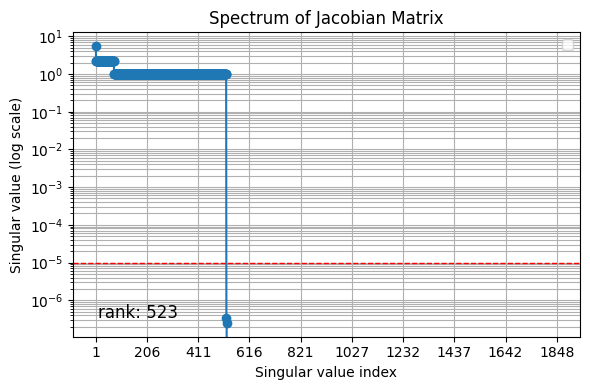

np.int64(523)

In [34]:
#J1 = torch.einsum('IJab,a -> IJb',k,psi)
#J1 -= torch.einsum('IJ,a -> IJa',rdm,psi)
J1 = J1.reshape(num_I**2,num_a)
#J2 = torch.einsum('IJab,b -> IJa',k,psi)
#J2 -= torch.einsum('IJ,a -> IJa',rdm,psi)
J2 = J2.reshape(num_I**2,num_a)
J = torch.cat((J1,J2),dim=1)
print(J.shape)
s = torch.linalg.svdvals(J)
plot_spectrum(np.array(s))